# True Unfixed Polynomial Regression with SGD

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic polynomial data with randomly generated coefficients. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error over 20 randomized trials. Here, we aim to assess how SGD performs when the model matches the true data-generating process as well as overfitting and underfitting with different degrees.


In [ ]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import generate_training_data_unfixed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

### Summary of Train/Test Error Over 20 Runs

We generate new synthetic data each time and report mean ± std of final losses.

In [3]:
degrees = [1, 2, 3, 4]
n_runs = 20
noise = 0.01
m, n = 100, 2

results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}
    
    for run in range(n_runs):
        X_poly, y, _ = generate_training_data_unfixed(
            m=m, n=n, noise=noise, model_type='polynomial', degree=3
        )

        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)
        sgd = SGD(X_train, y_train, num_iterations=5000)

        for method in ["fixed", "halving", "diminishing"]:
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])
            test_pred = X_test @ w
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print summary
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")



Degree 1:
Fixed Results:
  Train Loss  - Mean: 0.0182, Std: 0.0202
  Test Loss   - Mean: 0.0326, Std: 0.0328
Halving Results:
  Train Loss  - Mean: 0.0191, Std: 0.0211
  Test Loss   - Mean: 0.0357, Std: 0.0361
Diminishing Results:
  Train Loss  - Mean: 0.0180, Std: 0.0201
  Test Loss   - Mean: 0.0338, Std: 0.0341

Degree 2:
Fixed Results:
  Train Loss  - Mean: 0.0130, Std: 0.0311
  Test Loss   - Mean: 0.0344, Std: 0.0893
Halving Results:
  Train Loss  - Mean: 0.0137, Std: 0.0310
  Test Loss   - Mean: 0.0353, Std: 0.0876
Diminishing Results:
  Train Loss  - Mean: 0.0130, Std: 0.0310
  Test Loss   - Mean: 0.0343, Std: 0.0885

Degree 3:
Fixed Results:
  Train Loss  - Mean: 0.0135, Std: 0.0163
  Test Loss   - Mean: 0.0421, Std: 0.0591
Halving Results:
  Train Loss  - Mean: 0.0150, Std: 0.0183
  Test Loss   - Mean: 0.0428, Std: 0.0601
Diminishing Results:
  Train Loss  - Mean: 0.0136, Std: 0.0165
  Test Loss   - Mean: 0.0425, Std: 0.0599

Degree 4:
Fixed Results:
  Train Loss  - Mean: 0.04

### Convergence Plots (Single Run)

Here, we show the distance to optimum, gradient norm, and suboptimality gap over 5000 iterations on one synthetic dataset for polynomial degree 3 for the correct model type.

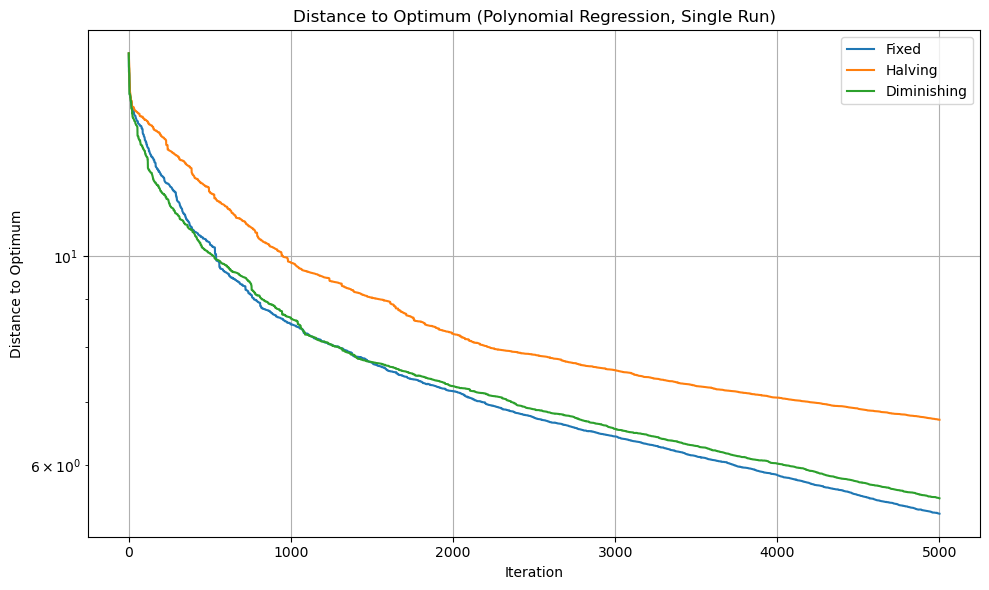

In [5]:
X, y, true_params = generate_training_data_unfixed(m=00, n=2, noise=0.01, model_type='polynomial', degree=3)
sgd = SGD(X, y, num_iterations=5000, noise=0.01)

results = {}
for method in ["fixed", "halving", "diminishing"]:
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {
        "w": w,
        "obj": obj,
        "grad": grad,
        "dist": dist
    }

# Plot: Distance to optimum vs. iteration
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

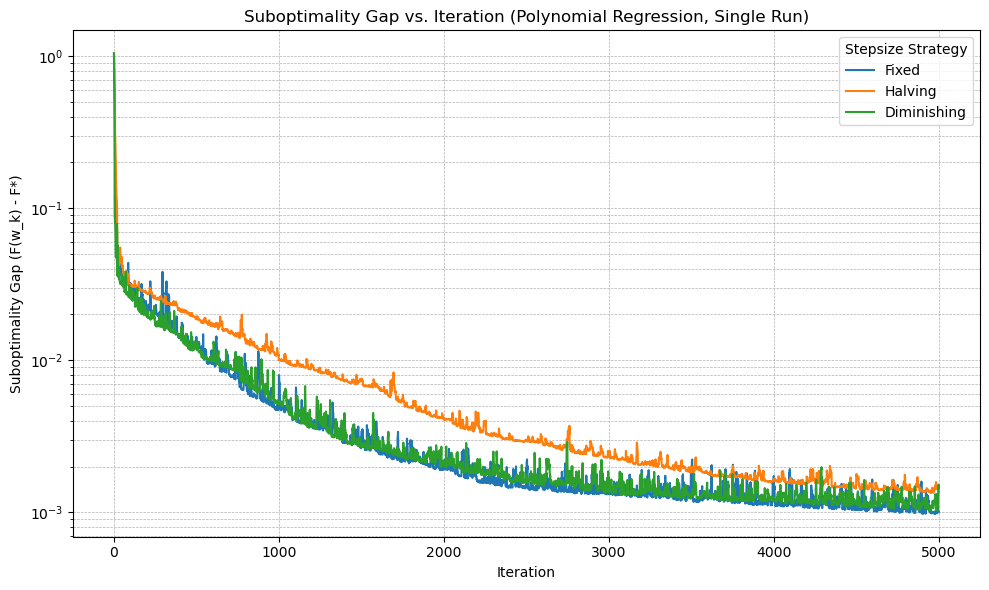

In [6]:
plt.figure(figsize=(10, 6))
plt.yscale("log")

for method in results:
    subopt_gap = results[method]["obj"] - sgd.F_star
    plt.plot(subopt_gap, label=method.capitalize())

plt.xlabel("Iteration")
plt.ylabel("Suboptimality Gap (F(w_k) - F*)")
plt.title("Suboptimality Gap vs. Iteration (Polynomial Regression, Single Run)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Stepsize Strategy")
plt.tight_layout()
plt.show()

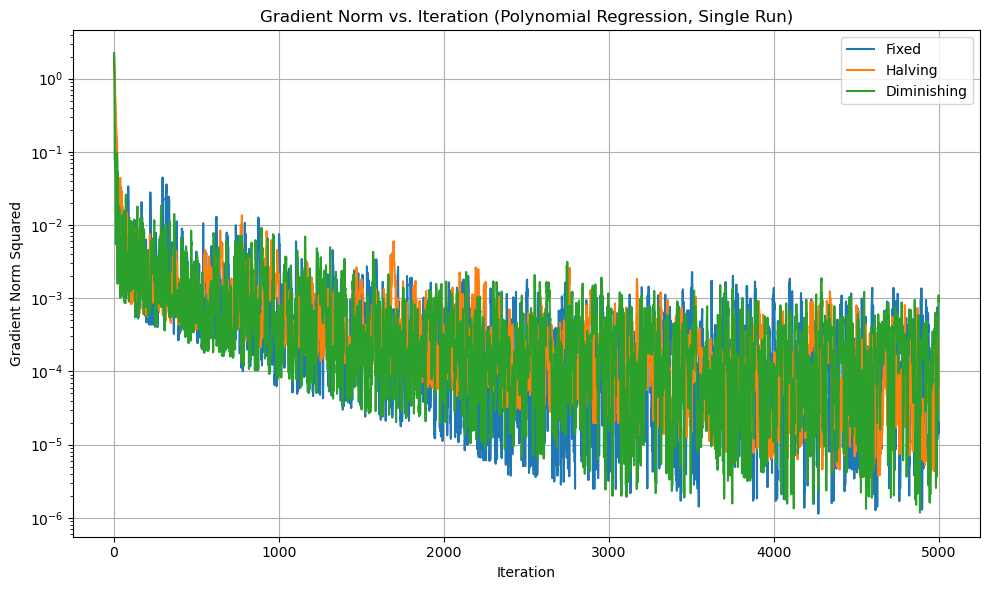

In [7]:
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["grad"], label=method.capitalize())  
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Theoretical Constants

The following constants were computed from the problem to derive the various stepsizes.

In [9]:

print("SGD Parameters for Unfixed Polynomial Run:")
print("="*60)
print(f"L (Lipschitz constant): {sgd.L:.4f}")
print(f"c: {sgd.c:.4f}")
print(f"M_G: {sgd.M_G:.4f}")
print(f"M: {sgd.M:.4f}")
print(f"M_V: {sgd.M_V:.4f}")
print(f"mu: {sgd.mu:.4f}")
print(f"mu_G: {sgd.mu_G:.4f}")
print(f"Diminishing stepsize (beta): {sgd.beta:.6f}")
print(f"Diminishing stepsize (gama): {sgd.gamma:.6f} \n")
print(f"Fixed stepsize (alpha): {sgd.fixed_alpha:.6f}")

print("\n" + "="*60)
print("True Parameters (used to generate synthetic data):")
print(f"A: {true_params['A']}")
print(f"b: {true_params['b']}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,w_2: {w_method[1:]}")

SGD Parameters for Unfixed Polynomial Run:
L (Lipschitz constant): 1.0216
c: 0.0001
M_G: 7.9987
M: 0.0001
M_V: 6.9987
mu: 1.0000
mu_G: 1.0000
Diminishing stepsize (beta): 7165.607881
Diminishing stepsize (gama): 58554.576355 

Fixed stepsize (alpha): 0.122373

True Parameters (used to generate synthetic data):
A: [ 0.30300738  2.21355255  0.12953757  0.9416473   0.09344711  1.85316736
  0.02476731 -0.47988808 -1.26870924]
b: -0.2964762029043869

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): -0.3455
  Weights (w_1,w_2: [ 1.7838561   0.83948205  1.07680821 -0.12516543  1.22769611  0.65602679
 -0.75285691 -0.78719692]
Halving stepsize:
  Bias term (w_0): -0.2592
  Weights (w_1,w_2: [ 1.79536797  0.74642099  0.90297451 -0.19946187  1.13995609  0.79245249
 -0.6053157  -0.74836091]
Diminishing stepsize:
  Bias term (w_0): -0.3650
  Weights (w_1,w_2: [ 1.81196824  0.78886229  1.02226397 -0.138319